# Batch Inference Pipeline

This notebook demonstrates a batch inference pipeline for air quality prediction. The workflow includes:

1. **Data Preparation**: Loading and preparing historical air quality and weather data.
2. **Model Retrieval**: Fetching the pre-trained air quality prediction model from the model registry.
3. **Feature Engineering**: Creating features required for the model, including lagged PM2.5 values and weather parameters.
4. **Batch Prediction**: Using the model to predict future PM2.5 values based on the prepared features.
5. **Result Visualization**: Plotting the predicted PM2.5 values and saving the plots.
6. **Monitoring**: Inserting the predictions into a feature group for monitoring and evaluation.

The pipeline ensures that the predictions are continuously updated and monitored for accuracy.

In [184]:
from datetime import datetime, timedelta, timezone
import pandas as pd
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
import hopsworks
import json
import util
import os

In [185]:
today = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)
yesterday = today - timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 0, 0)

In [186]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']
url=location['aqicn_url']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1157270
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [187]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

Model registry

In [188]:
mr= project.get_model_registry()

retrieved_model=mr.get_model(
    name="air_quality_model",
    version=1,
)

saved_model_dir=retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [189]:
import joblib

retrieved_sklearn_model=joblib.load(saved_model_dir+"/model.pkl")

retrieved_sklearn_model

GradientBoostingRegressor()

In [190]:
weather_fg= fs.get_feature_group(
    name='weather',
    version=1,
)

batch_data= weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values(by=['date']).reset_index(drop=True)

batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.67s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-19 00:00:00+00:00,-0.10,0.0,4.024922,79.695213,stockholm
1,2024-11-20 00:00:00+00:00,1.10,0.4,24.609364,354.122711,stockholm
2,2024-11-21 00:00:00+00:00,-2.70,0.2,28.401239,300.465454,stockholm
3,2024-11-22 00:00:00+00:00,-5.40,0.0,10.805999,271.909119,stockholm
4,2024-11-23 00:00:00+00:00,-3.45,0.0,13.202726,295.866302,stockholm
5,2024-11-24 00:00:00+00:00,2.65,0.0,15.141414,161.995743,stockholm
6,2024-11-25 00:00:00+00:00,5.55,0.0,15.807239,210.068497,stockholm
7,2024-11-26 00:00:00+00:00,7.85,0.0,22.183128,221.710663,stockholm
8,2024-11-27 00:00:00+00:00,1.55,0.0,9.659814,296.564972,stockholm
9,2024-11-28 00:00:00+00:00,2.80,0.0,16.199999,233.130020,stockholm


In [191]:
def get_pm25_value(row):
    """
    Returns the actual pm25 value if it exists (not NaN),
    otherwise returns the predicted_pm25 value.
    """
    return row['pm25'] if not pd.isna(row['pm25']) else row['predicted_pm25']


air_quality_fg= fs.get_feature_group(
    name='air_quality',
    version=1,
)


aq_batch_data= air_quality_fg.filter(air_quality_fg.date >= yesterday).read()       #Only need todays for future predictions. Makes it a dataframe
aq_batch_data = aq_batch_data.sort_values(by=['date']).reset_index(drop=True)

df_combined = pd.merge(
    aq_batch_data,
    batch_data,
    on='date',
    how='outer',  # Use 'outer' as we want all rows
)

for index in range(len(batch_data)):
    current_day=df_combined.loc[index,['date']]
  
    df_combined.at[index+1, 'pm25_1_days_before'] = get_pm25_value(df_combined.loc[index])
    df_combined.at[index+1,'pm25_2_days_before']=df_combined.loc[index,'pm25_1_days_before']
    df_combined.at[index+1,'pm25_3_days_before']=df_combined.loc[index,'pm25_2_days_before']

    
    current_features=df_combined.loc[index+1, ['pm25_1_days_before', 'pm25_2_days_before','pm25_3_days_before','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]

    current_features = pd.DataFrame(current_features.astype(float)).T       #Convert series to dataframe, and make sure the values are floats.
    next_pred=retrieved_sklearn_model.predict(current_features)
    df_combined.at[index+1,'predicted_pm25']=next_pred
    batch_data.at[index, 'predicted_pm25']=next_pred            #Has one less row, so starts earlier in index

batch_data.info()




Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 
2024-11-19 16:29:08,790 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23.035758867148296' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

2024-11-19 16:29:08,793 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23.035758867148296' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

2024-11-19 16:29:08,797 WARNING: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23.035758867148296' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                   

In [192]:
# Drop the first row, as it is today's date
batch_data.dropna(inplace=True)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-19 00:00:00+00:00,-0.10,0.0,4.024922,79.695213,stockholm,43.850216
1,2024-11-20 00:00:00+00:00,1.10,0.4,24.609364,354.122711,stockholm,23.035759
2,2024-11-21 00:00:00+00:00,-2.70,0.2,28.401239,300.465454,stockholm,22.900836
3,2024-11-22 00:00:00+00:00,-5.40,0.0,10.805999,271.909119,stockholm,30.832074
4,2024-11-23 00:00:00+00:00,-3.45,0.0,13.202726,295.866302,stockholm,30.034343
5,2024-11-24 00:00:00+00:00,2.65,0.0,15.141414,161.995743,stockholm,33.622803
6,2024-11-25 00:00:00+00:00,5.55,0.0,15.807239,210.068497,stockholm,36.179437
7,2024-11-26 00:00:00+00:00,7.85,0.0,22.183128,221.710663,stockholm,33.622904
8,2024-11-27 00:00:00+00:00,1.55,0.0,9.659814,296.564972,stockholm,39.517985
9,2024-11-28 00:00:00+00:00,2.80,0.0,16.199999,233.130020,stockholm,39.724593


In [193]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data['predicted_pm25'] = batch_data['predicted_pm25'].astype("float32")
batch_data = batch_data.sort_values(by=['date'])

In [194]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,-0.10,0.0,4.024922,79.695213,stockholm,43.850216,stockholm-st-eriksgatan-83,sweden,1
1,2024-11-20 00:00:00+00:00,1.10,0.4,24.609364,354.122711,stockholm,23.035759,stockholm-st-eriksgatan-83,sweden,2
2,2024-11-21 00:00:00+00:00,-2.70,0.2,28.401239,300.465454,stockholm,22.900837,stockholm-st-eriksgatan-83,sweden,3
3,2024-11-22 00:00:00+00:00,-5.40,0.0,10.805999,271.909119,stockholm,30.832073,stockholm-st-eriksgatan-83,sweden,4
4,2024-11-23 00:00:00+00:00,-3.45,0.0,13.202726,295.866302,stockholm,30.034344,stockholm-st-eriksgatan-83,sweden,5
5,2024-11-24 00:00:00+00:00,2.65,0.0,15.141414,161.995743,stockholm,33.622803,stockholm-st-eriksgatan-83,sweden,6
6,2024-11-25 00:00:00+00:00,5.55,0.0,15.807239,210.068497,stockholm,36.179436,stockholm-st-eriksgatan-83,sweden,7
7,2024-11-26 00:00:00+00:00,7.85,0.0,22.183128,221.710663,stockholm,33.622902,stockholm-st-eriksgatan-83,sweden,8
8,2024-11-27 00:00:00+00:00,1.55,0.0,9.659814,296.564972,stockholm,39.517986,stockholm-st-eriksgatan-83,sweden,9
9,2024-11-28 00:00:00+00:00,2.80,0.0,16.199999,233.130020,stockholm,39.724594,stockholm-st-eriksgatan-83,sweden,10


In [195]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         10 non-null     datetime64[us, UTC]
 1   temperature_2m_mean          10 non-null     float32            
 2   precipitation_sum            10 non-null     float32            
 3   wind_speed_10m_max           10 non-null     float32            
 4   wind_direction_10m_dominant  10 non-null     float32            
 5   city                         10 non-null     object             
 6   predicted_pm25               10 non-null     float32            
 7   street                       10 non-null     object             
 8   country                      10 non-null     object             
 9   days_before_forecast_day     10 non-null     int64              
dtypes: datetime64[us, UTC](1), float32(5), int64(1), obje

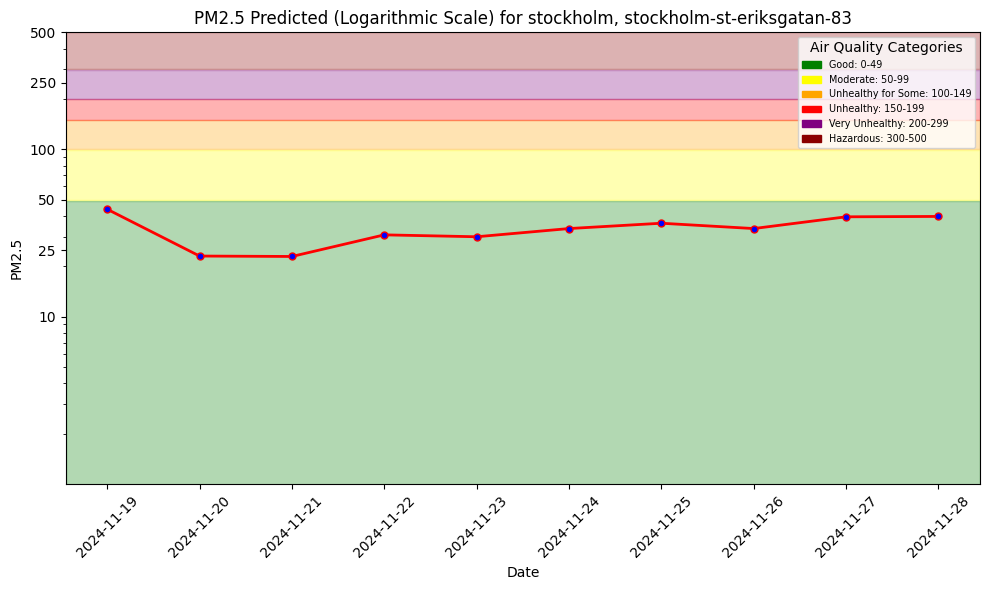

In [196]:
file_path = "docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [197]:
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [198]:
print(batch_data.head())
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

                       date  temperature_2m_mean  precipitation_sum  \
0 2024-11-19 00:00:00+00:00                -0.10                0.0   
1 2024-11-20 00:00:00+00:00                 1.10                0.4   
2 2024-11-21 00:00:00+00:00                -2.70                0.2   
3 2024-11-22 00:00:00+00:00                -5.40                0.0   
4 2024-11-23 00:00:00+00:00                -3.45                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant       city  predicted_pm25  \
0            4.024922                    79.695213  stockholm       43.850216   
1           24.609364                   354.122711  stockholm       23.035759   
2           28.401239                   300.465454  stockholm       22.900837   
3           10.805999                   271.909119  stockholm       30.832073   
4           13.202726                   295.866302  stockholm       30.034344   

                       street country  days_before_forecast_day  
0  stockholm-st-erik

Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1157270/jobs/named/aq_predictions_1_offline_fg_materialization/executions


KeyboardInterrupt: 

In [199]:
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-19 00:00:00+00:00,-0.1,0.0,4.024922,79.695213,stockholm,36.641205,stockholm-st-eriksgatan-83,sweden,1


In [200]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.31s) 


,date,pm25,country,city,street,url,pm25_1_days_before,pm25_2_days_before,pm25_3_days_before,pm25_avg_3_days_before
0,2021-06-27 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,27.0,37.0,26.0,30.000000
1,2023-12-15 00:00:00+00:00,24.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,19.0,21.0,25.0,21.666666
2,2024-09-22 00:00:00+00:00,10.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,19.0,23.0,24.0,22.000000
3,2021-11-09 00:00:00+00:00,20.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,14.0,9.0,13.0,12.000000
4,2021-04-24 00:00:00+00:00,9.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,12.0,17.0,26.0,18.333334
...,...,...,...,...,...,...,...,...,...,...
2136,2019-03-24 00:00:00+00:00,25.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,31.0,28.0,26.0,28.333334
2137,2020-03-13 00:00:00+00:00,17.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,16.0,26.0,33.0,25.000000
2138,2021-01-18 00:00:00+00:00,26.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,18.0,16.0,20.0,18.000000
2139,2024-11-18 00:00:00+00:00,32.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523,14.0,13.0,22.0,16.333334


In [ ]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_sklearn_model)
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-19 00:00:00+00:00,36.641205,46.0


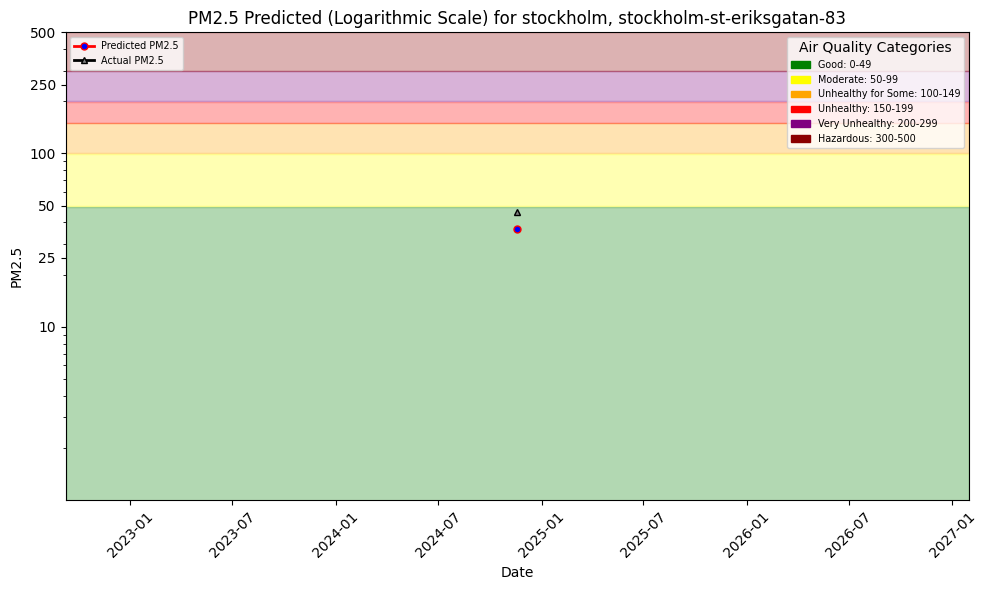

In [202]:
file_path = "docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()